<a href="https://colab.research.google.com/github/jrleonett/Error-ELA-and-Imagen-MetadataImagen/blob/main/Analisis_Error_ELA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis Forense de Imágenes con Error Level Analysis (ELA) ✔
Este programa es una herramienta de computación forense diseñada para analizar imágenes en busca de evidencia de manipulación o edición. Utiliza técnicas avanzadas como el Error Level Analysis (ELA) para detectar áreas de una imagen que han sido modificadas o alteradas. Además, realiza un análisis exhaustivo de los metadatos de la imagen, incluyendo la fecha de creación, la última modificación y el software utilizado para editarla.

El programa es ideal para peritos forenses digitales, analistas de seguridad y cualquier persona interesada en verificar la autenticidad de imágenes digitales.

# Funcionalidades principales
01.- Error Level Analysis (ELA):


* Detecta áreas de una imagen que han sido modificadas o editadas.
* Muestra la imagen original junto con la imagen de ELA para comparar las diferencias.
* Ajusta el brillo y el contraste para resaltar las áreas modificadas.
* Ajusta el brillo y el contraste para resaltar las áreas modificadas.

02.- Análisis de metadatos:

* Extrae y muestra información detallada de los metadatos de la imagen, como:

* Fecha y hora de la captura.
* Fabricante y modelo de la cámara.
* Software utilizado para editar la imagen.
* Coordenadas GPS (si están disponibles).

03.- Verificación de manipulación:

* Analiza si la imagen ha sido manipulada o alterada en función de los metadatos y el ELA.
* Proporciona razones específicas si se detecta manipulación.

04.- Exportación de resultados:
Guarda los resultados del análisis en un archivo ZIP que incluye:

*A rchivo de texto con los metadatos y el análisis de manipulación.
* Imagen original.
* Imagen con ELA.

Cómo usar el programa
Configuración del entorno:

Ejecuta la primera celda del programa para configurar el entorno y crear la carpeta EVIDENCIA.

Coloca tu archivo de imagen (.png o .jpg) en la carpeta EVIDENCIA.

Procesamiento de la imagen:

Ejecuta la segunda celda para procesar la imagen y realizar el análisis de ELA.

El programa mostrará la imagen original y la imagen con ELA en una figura.

Resultados:

Los resultados del análisis se guardarán en un archivo ZIP en la carpeta EVIDENCIA.

El archivo ZIP incluirá:

Archivo de texto con los metadatos y el análisis de manipulación.

Imagen original.

Imagen con ELA.

In [ ]:
#@title [01] Configuración del entorno
%%capture
import os
import shutil
import zipfile  # Importar el módulo zipfile

# Creación de la carpeta "EVIDENCIA"
carpeta = "EVIDENCIA"
if not os.path.exists(carpeta):
    os.mkdir(carpeta)
    print(f"Carpeta '{carpeta}' creada. Por favor, coloca tu archivo de imagen (.png o .jpg) en esta carpeta.")
else:
    print(f"La carpeta '{carpeta}' ya existe. Asegúrate de colocar tu archivo de imagen (.png o .jpg) en esta carpeta.")

# Instalación de las bibliotecas necesarias
!pip install pillow opencv-python

# Verificación de la GPU asignada (opcional)
!nvidia-smi
!/usr/local/cuda/bin/nvcc --version

Procesando archivo: EVIDENCIA/fuentedeagua.jpg
Imagen cargada: EVIDENCIA/fuentedeagua.jpg

    Información básica de la imagen:
    Formato: JPEG
    Tamaño: (2592, 1552) píxeles
    Modo: RGB
    

ANÁLISIS FORENSE DE LOS METADATOS DE LA IMAGEN:
Información de ubicación GPS:
- Coordenadas GPS: 49.60928888888889, 6.131049999999999
- Enlace a Google Maps: https://www.google.com/maps?q=49.60928888888889,6.131049999999999
ResolutionUnit: 2
ExifOffset: 172
Fabricante de la cámara: ASUS
Modelo de la cámara: M10
Software utilizado para editar la imagen: Asus Camera 2.0
Orientation: 1
YCbCrPositioning: 1
XResolution: 72.0
YResolution: 72.0
ExifVersion: b'0220'
ComponentsConfiguration: b'\x01\x02\x03\x00'
FlashPixVersion: b'0100'
DateTimeOriginal: 2011:08:28 14:46:28
DateTimeDigitized: 2011:08:28 14:46:28
ColorSpace: 1
Ancho de la imagen: 2592 píxeles
Alto de la imagen: 1552 píxeles
ExifInteroperabilityOffset: 362
FileSource: b'\x03'
SceneType: b'\x01'
WhiteBalance: 0


Análisis de manipulació

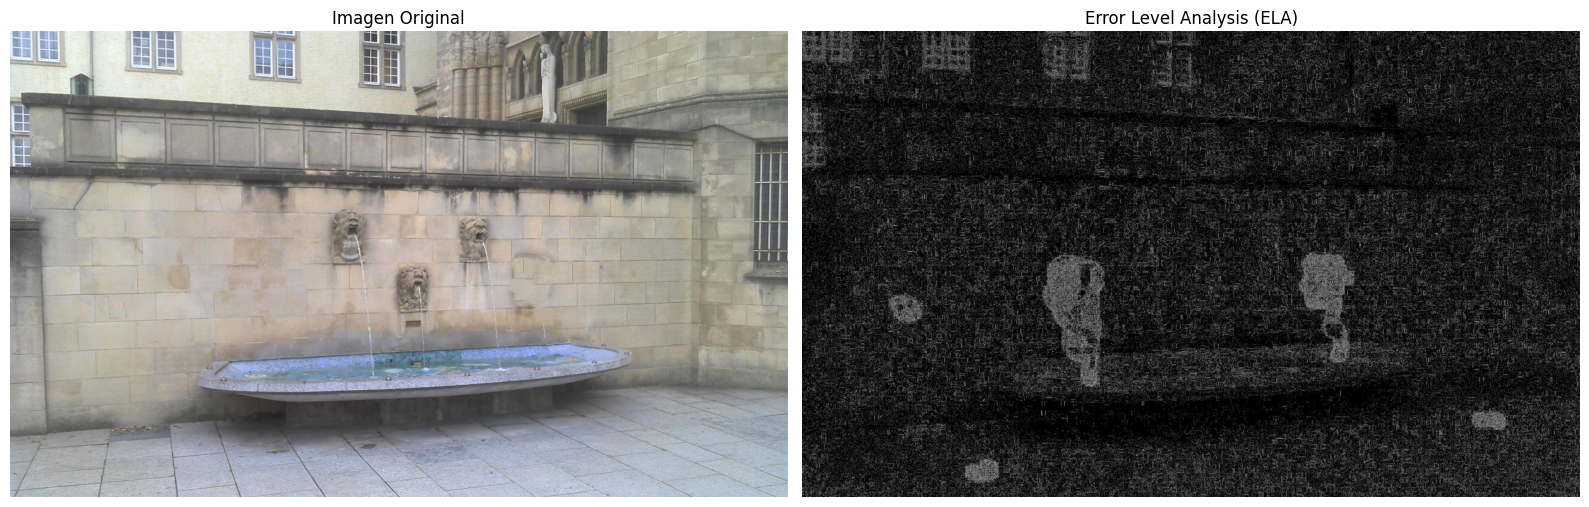


Archivos generados y comprimidos en: EVIDENCIA/fuentedeagua_errorELA.zip


In [ ]:
#@title [02] Procesamiento de la imagen y análisis con ELA
import os
import cv2
import numpy as np
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
import hashlib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, FileLink

def obtener_metadatos(imagen):
    """
    Obtiene los metadatos de la imagen.
    """
    metadatos = {}
    try:
        exif_data = imagen._getexif()
        if exif_data:
            for tag_id, value in exif_data.items():
                tag = TAGS.get(tag_id, tag_id)
                metadatos[tag] = value
    except Exception as e:
        print(f"Error al obtener metadatos: {e}")
    return metadatos

def obtener_coordenadas(exif_data):
    """
    Obtiene las coordenadas GPS de los metadatos EXIF.
    """
    if not exif_data:
        return None

    gps_info = exif_data.get("GPSInfo", {})
    if not gps_info:
        return None

    # Convertir las coordenadas GPS a grados decimales
    def gps_to_degrees(value):
        d, m, s = value
        return d + (m / 60.0) + (s / 3600.0)

    try:
        latitud = gps_info.get(2)  # Latitud
        longitud = gps_info.get(4)  # Longitud
        latitud_ref = gps_info.get(1)  # Norte/Sur
        longitud_ref = gps_info.get(3)  # Este/Oeste

        if latitud and longitud and latitud_ref and longitud_ref:
            latitud = gps_to_degrees(latitud)
            longitud = gps_to_degrees(longitud)
            if latitud_ref == "S":  # Si es Sur, convertir a negativo
                latitud = -latitud
            if longitud_ref == "W":  # Si es Oeste, convertir a negativo
                longitud = -longitud
            return latitud, longitud
    except Exception as e:
        print(f"Error al procesar coordenadas GPS: {e}")
        return None

    return None

def calcular_hash(imagen):
    """
    Calcula el hash MD5 de la imagen para verificar su integridad.
    """
    imagen_bytes = imagen.tobytes()
    return hashlib.md5(imagen_bytes).hexdigest()

def analizar_manipulacion(imagen, metadatos):
    """
    Analiza si la imagen ha sido manipulada.
    """
    manipulada = False
    razones = []

    # Verificar si la imagen tiene marcas de agua
    if imagen.mode == "P":
        razones.append("La imagen tiene marcas de agua o es una imagen indexada.")
        manipulada = True

    # Verificar si los metadatos han sido alterados
    if not metadatos:
        razones.append("La imagen no tiene metadatos EXIF.")
        manipulada = True
    else:
        if "Software" in metadatos:
            razones.append(f"La imagen fue editada con: {metadatos['Software']}")
            manipulada = True

    # Verificar si el hash de la imagen coincide con un hash conocido (simulación)
    hash_conocido = "1a79a4d60de6718e8e5b326e338ae533"  # Hash de ejemplo
    hash_actual = calcular_hash(imagen)
    if hash_actual != hash_conocido:
        razones.append("El hash de la imagen no coincide con el hash conocido.")
        manipulada = True

    return manipulada, razones

def realizar_ela(imagen, quality=95, scale=100):
    """
    Realiza el Error Level Analysis (ELA) en la imagen utilizando OpenCV.
    """
    # Convertir la imagen a formato compatible con OpenCV
    imagen_cv = cv2.cvtColor(np.array(imagen), cv2.COLOR_RGB2BGR)

    # Guardar la imagen comprimida
    temp_path = "temp_image.jpg"
    cv2.imwrite(temp_path, imagen_cv, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # Leer la imagen comprimida
    imagen_comprimida = cv2.imread(temp_path)

    # Calcular la diferencia absoluta entre la imagen original y la comprimida
    diferencia = cv2.absdiff(imagen_cv, imagen_comprimida)

    # Escalar la diferencia para resaltar las áreas modificadas
    ela_imagen = scale * diferencia

    # Convertir a escala de grises para mejorar la visualización
    ela_imagen = cv2.cvtColor(ela_imagen, cv2.COLOR_BGR2GRAY)

    # Eliminar el archivo temporal
    os.remove(temp_path)

    return ela_imagen

def procesar_imagen(archivo_imagen):
    # Cargar la imagen
    try:
        imagen = Image.open(archivo_imagen)
        print(f"Imagen cargada: {archivo_imagen}")
    except Exception as e:
        print(f"Error al cargar la imagen: {e}")
        return

    # Obtener información básica de la imagen
    info_basica = f"""
    Información básica de la imagen:
    Formato: {imagen.format}
    Tamaño: {imagen.size} píxeles
    Modo: {imagen.mode}
    """
    print(info_basica)

    # Obtener metadatos
    metadatos = obtener_metadatos(imagen)
    info_metadatos = "\nANÁLISIS FORENSE DE LOS METADATOS DE LA IMAGEN:\n"
    if metadatos:
        for tag, value in metadatos.items():
            if tag == "DateTime":
                info_metadatos += f"Fecha y hora de la captura: {value}\n"
            elif tag == "Make":
                info_metadatos += f"Fabricante de la cámara: {value}\n"
            elif tag == "Model":
                info_metadatos += f"Modelo de la cámara: {value}\n"
            elif tag == "Software":
                info_metadatos += f"Software utilizado para editar la imagen: {value}\n"
            elif tag == "ExifImageWidth":
                info_metadatos += f"Ancho de la imagen: {value} píxeles\n"
            elif tag == "ExifImageHeight":
                info_metadatos += f"Alto de la imagen: {value} píxeles\n"
            elif tag == "GPSInfo":
                info_metadatos += "Información de ubicación GPS:\n"
                coordenadas = obtener_coordenadas(metadatos)
                if coordenadas:
                    latitud, longitud = coordenadas
                    enlace_google_maps = f"https://www.google.com/maps?q={latitud},{longitud}"
                    info_metadatos += f"- Coordenadas GPS: {latitud}, {longitud}\n"
                    info_metadatos += f"- Enlace a Google Maps: {enlace_google_maps}\n"
                else:
                    info_metadatos += "- No se encontraron coordenadas GPS.\n"
            else:
                info_metadatos += f"{tag}: {value}\n"
    else:
        info_metadatos += "No se encontraron metadatos.\n"
    print(info_metadatos)

    # Analizar si la imagen ha sido manipulada
    manipulada, razones = analizar_manipulacion(imagen, metadatos)
    info_manipulacion = "\nAnálisis de manipulación:\n"
    if manipulada:
        info_manipulacion += "La imagen ha sido manipulada.\n"
        info_manipulacion += "Razones:\n"
        for razon in razones:
            info_manipulacion += f"- {razon}\n"
    else:
        info_manipulacion += "La imagen NO ha sido manipulada.\n"
    print(info_manipulacion)

    # Guardar la información en un archivo de texto
    nombre_imagen = os.path.basename(archivo_imagen).split(".")[0]
    archivo_texto = os.path.join("EVIDENCIA", f"{nombre_imagen}_analisis.txt")
    with open(archivo_texto, "w") as f:
        f.write(info_basica)
        f.write(info_metadatos)
        f.write(info_manipulacion)

    # Realizar Error Level Analysis (ELA)
    print("\nRealizando Error Level Analysis (ELA)...")
    ela_imagen = realizar_ela(imagen)

    # Mostrar el resultado del ELA
    print("\nResultado ELA al 95%:")

    # Mostrar la imagen original y la imagen con ELA
    plt.figure(figsize=(16, 8))

    # Imagen original
    plt.subplot(1, 2, 1)
    plt.imshow(imagen)
    plt.title("Imagen Original")
    plt.axis("off")

    # Imagen con ELA
    plt.subplot(1, 2, 2)
    plt.imshow(ela_imagen, cmap="gray")
    plt.title("Error Level Analysis (ELA)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Guardar la imagen original y la imagen con ELA
    imagen.save(os.path.join("EVIDENCIA", f"{nombre_imagen}_original.jpg"))
    cv2.imwrite(os.path.join("EVIDENCIA", f"{nombre_imagen}_ela.jpg"), ela_imagen)

    # Crear un archivo ZIP con los archivos generados
    archivo_zip = os.path.join("EVIDENCIA", f"{nombre_imagen}_errorELA.zip")
    with zipfile.ZipFile(archivo_zip, "w") as zipf:
        zipf.write(archivo_texto, os.path.basename(archivo_texto))
        zipf.write(os.path.join("EVIDENCIA", f"{nombre_imagen}_original.jpg"), f"{nombre_imagen}_original.jpg")
        zipf.write(os.path.join("EVIDENCIA", f"{nombre_imagen}_ela.jpg"), f"{nombre_imagen}_ela.jpg")

    # Eliminar archivos temporales
    os.remove(archivo_texto)
    os.remove(os.path.join("EVIDENCIA", f"{nombre_imagen}_original.jpg"))
    os.remove(os.path.join("EVIDENCIA", f"{nombre_imagen}_ela.jpg"))

    print(f"\nArchivos generados y comprimidos en: {archivo_zip}")

# Verificar si la carpeta "EVIDENCIA" existe y buscar el archivo de imagen
carpeta = "EVIDENCIA"
if os.path.exists(carpeta):
    archivos = os.listdir(carpeta)
    archivos_imagen = [archivo for archivo in archivos if archivo.endswith((".png", ".jpg"))]

    if len(archivos_imagen) == 0:
        print("No se encontraron archivos de imagen en la carpeta 'EVIDENCIA'. Por favor, coloca un archivo de imagen (.png o .jpg) en esta carpeta.")
    else:
        # Tomar el primer archivo de imagen encontrado
        archivo_imagen = os.path.join(carpeta, archivos_imagen[0])
        print(f"Procesando archivo: {archivo_imagen}")
        procesar_imagen(archivo_imagen)
else:
    print("La carpeta 'EVIDENCIA' no existe. Por favor, ejecuta la primera parte del código para crearla.")